# Classification using TidyModels
(This programming assignment is just to understand extended functionality provided by tidy models. **Running and submitting the assignment will result in full credit**)

In this lab we would be going through:
- Naive Bayes
- K-Nearest Neighbours
- Poisson Regression

using TidyModels. 

For this lab, we would examining the `OJ` data set that contains a number of numeric variables plus a variable called `Purchase` which has the two labels `CH` and `MM` (which is Citrus Hill or Minute Maid Orange Juice)

In [1]:
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(ISLR))
suppressPackageStartupMessages(library(ISLR2))
suppressPackageStartupMessages(library(poissonreg))
suppressPackageStartupMessages(library(corrr))
suppressPackageStartupMessages(library(discrim))
suppressPackageStartupMessages(library(kknn))

In [2]:
oj_train <- OJ %>%
  filter(WeekofPurchase < 260)
dim(oj_train)

oj_test <- OJ %>%
  filter(WeekofPurchase >= 260)
dim(oj_test)

dim(OJ)

[1] 600  18

[1] 470  18

[1] 1070   18

## Naive Bayes

We would be using the `naive_bayes()` function to create the specification and also set the usekernel argument to `FALSE`.

This means that we are assuming that the predictors `PriceCH` and `PriceMM` are drawn from Gaussian distributions.

In [3]:
nb_spec <- naive_Bayes() %>% 
  set_mode("classification") %>% 
  set_engine("klaR") %>% 
  set_args(usekernel = FALSE)  

nb_fit <- nb_spec %>% 
  fit(Purchase ~ PriceCH + PriceMM, data = oj_train)

In [4]:
names(nb_fit)

[1] "lvl"     "spec"    "fit"     "preproc" "elapsed"

In [5]:
#confusion matrix
augment(nb_fit, new_data = oj_test) %>% 
  conf_mat(truth = Purchase, estimate = .pred_class)

#accuracy
augment(nb_fit, new_data = oj_test) %>% 
  accuracy(truth = Purchase, estimate = .pred_class)

          Truth
Prediction  CH  MM
        CH 308 162
        MM   0   0

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6553191


`geom_smooth()` using formula 'y ~ x'



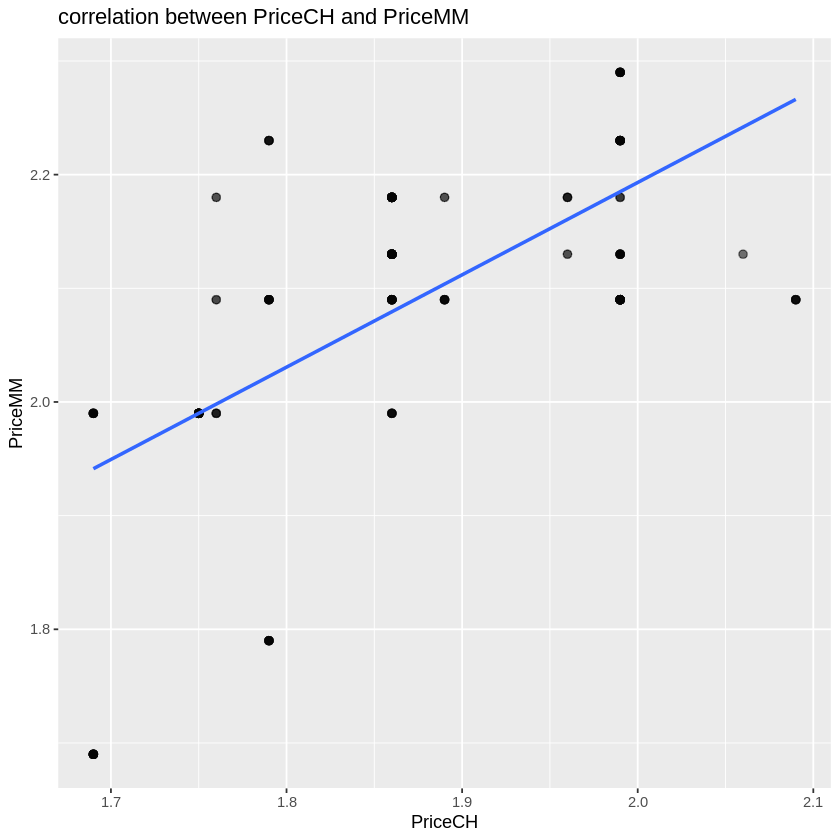

In [6]:
ggplot(OJ, aes(PriceCH, PriceMM)) +
  geom_point(alpha = 0.1, size = 2) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "correlation between PriceCH and PriceMM")

## K - Nearest Neighbors

This is the first model we have looked at that has a hyperparameter we need to specify. 

I have set it to 5 with `neighbors = 5`. Fitting is done like normal.

In [7]:
knn_spec <- nearest_neighbor(neighbors = 5) %>%
  set_mode("classification") %>%
  set_engine("kknn")

knn_fit <- knn_spec %>%
  fit(Purchase ~ PriceCH + PriceMM, data = oj_train)

knn_fit

parsnip model object

Fit time:  19ms 

Call:
kknn::train.kknn(formula = Purchase ~ PriceCH + PriceMM, data = data,     ks = min_rows(5, data, 5))

Type of response variable: nominal
Minimal misclassification: 0.385
Best kernel: optimal
Best k: 5

In [8]:
augment(knn_fit, new_data = oj_test) %>%
  conf_mat(truth = Purchase, estimate = .pred_class) 

augment(knn_fit, new_data = oj_test) %>%
  accuracy(truth = Purchase, estimate = .pred_class) 

          Truth
Prediction  CH  MM
        CH 302 157
        MM   6   5

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6531915


It appears that this model is not performing that well.

We will try using a K-nearest neighbors model in an application to caravan insurance data. This data set includes `85` predictors that measure demographic characteristics for `5822` individuals. 

The response variable is Purchase, which indicates whether or not a given individual purchases a caravan insurance policy. In this data set, only 6% of people purchased caravan insurance.

In [9]:
Caravan_test <- Caravan[seq_len(1000), ]
Caravan_train <- Caravan[-seq_len(1000), ]

Since we are using a K-nearest neighbor model, it is importance that the variables are centered and scaled to make sure that the variables have a uniform influence. 

We can accomplish this transformation with `step_normalize()`, which does centering and scaling in one go

In [10]:
rec_spec <- recipe(Purchase ~ ., data = Caravan_train) %>%
  step_normalize(all_numeric_predictors())

In [11]:
Caravan_wf <- workflow() %>%
  add_recipe(rec_spec)

In [12]:
knn_spec <- nearest_neighbor() %>%
  set_mode("classification") %>%
  set_engine("kknn")

We can then use this model specification along with `Caravan_wf` to create 3 full workflow objects for `K = 1,3,5`

In [13]:
knn1_wf <- Caravan_wf %>%
  add_model(knn_spec %>% set_args(neighbors = 1))

knn3_wf <- Caravan_wf %>%
  add_model(knn_spec %>% set_args(neighbors = 3))

knn5_wf <- Caravan_wf %>%
  add_model(knn_spec %>% set_args(neighbors = 5))

With all these workflow specification we can fit all the models one by one.

In [14]:
knn1_fit <- fit(knn1_wf, data = Caravan_train)
knn3_fit <- fit(knn3_wf, data = Caravan_train)
knn5_fit <- fit(knn5_wf, data = Caravan_train)

In [15]:
get_confusion_matrix = function(fit){
    augment(fit, new_data = Caravan_test) %>%
  conf_mat(truth = Purchase, estimate = .pred_class)
}

get_accuracy = function(fit){
    augment(fit, new_data = Caravan_test) %>%
  accuracy(truth = Purchase, estimate = .pred_class)
}

get_confusion_matrix(knn1_fit)
get_confusion_matrix(knn3_fit)
get_confusion_matrix(knn5_fit)


get_accuracy(knn1_fit)
get_accuracy(knn3_fit)
get_accuracy(knn5_fit)

          Truth
Prediction  No Yes
       No  874  50
       Yes  67   9

          Truth
Prediction  No Yes
       No  875  50
       Yes  66   9

          Truth
Prediction  No Yes
       No  874  50
       Yes  67   9

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.883


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.884


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.883


And it appears that the model performance doesn’t change much when changing from 1 to 5.

## Poisson Regression

We will now shift to a new data set, Bikeshare, and look at the number of bike rentals per hour in Washington, D.C.

The variable of interest, number of bike rentals per hour can take on non-negative integer values. This makes Poisson Regression a suitable candidate to model the same.

We start with specifying the model using the `poisson_reg()` function.

In [16]:
pois_spec <- poisson_reg() %>% 
  set_mode("regression") %>% 
  set_engine("glm")

Here we will be predicting bikers using the following predictors:

* `mnth` - month of the year, coded as a factor
* `hr` - hour of the day, coded as a factor from 0 to 23
* `workingday` - Is it a workday? Already coded as a dummy variable with Yes = 1, No = 0
* `temp` - normalized temperature in Celsius
* `weathersit` - weather condition, again coded as a factor with the following levels:
    * clear
    * cloudy/misty
    * light rain/snow
    * heavy rain/snow
    
As we can see, apart from `temp` all other predictors are categorical in nature. Thus, we will first create a recipe to convert these into dummy variables and then bundle the model spec and recipe using a workflow.

In [17]:
pois_rec_spec <- recipe(
  bikers ~ mnth + hr + workingday + temp + weathersit,
  data = Bikeshare
) %>% 
  step_dummy(all_nominal_predictors())

In [18]:
pois_wf <- workflow() %>% 
  add_recipe(pois_rec_spec) %>% 
  add_model(pois_spec)

With the workflow in place, we follow the same pattern to fit the model and look at the predictions.

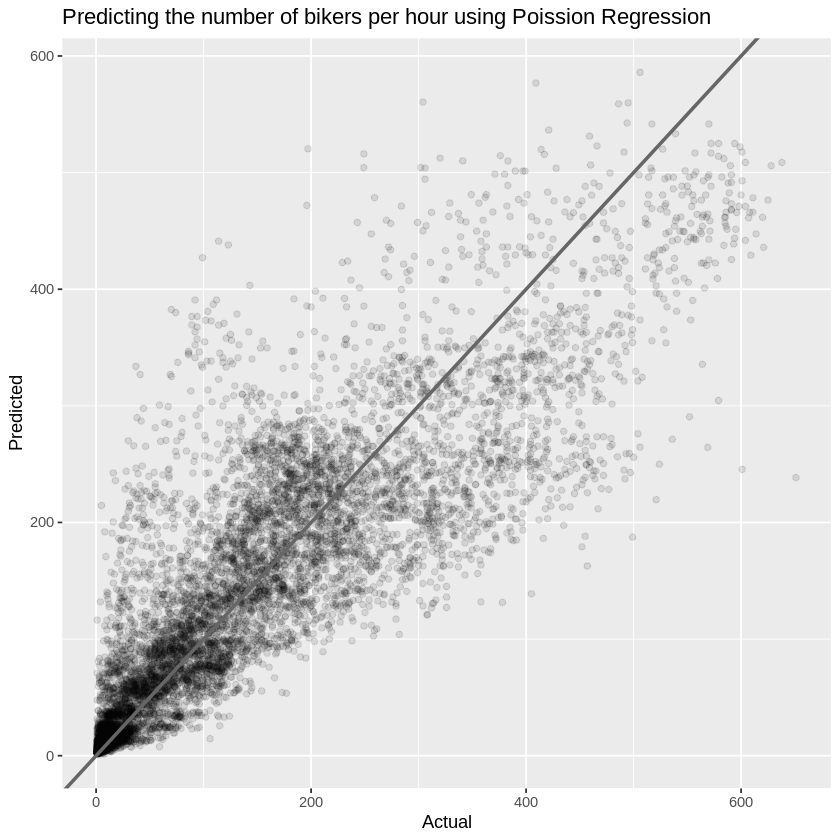

In [19]:
pois_fit <- pois_wf %>% fit(data = Bikeshare)

augment(pois_fit, new_data = Bikeshare, type.predict = "response") %>% 
  ggplot(aes(bikers, .pred)) +
  geom_point(alpha = 0.1) +
  geom_abline(slope = 1, size = 1, color = "grey40") +
  labs(title = "Predicting the number of bikers per hour using Poission Regression",
       x = "Actual", y = "Predicted")

We can also look at the model coefficients to get a feel for the working of the model and comparing it with our own understanding.

Looking at the coefficients corresponding to the mnth variable, we note that it is lower in the winter months and higher in the summer months. This seems logical as we would expect the number of bike rentals to be higher during summertime.

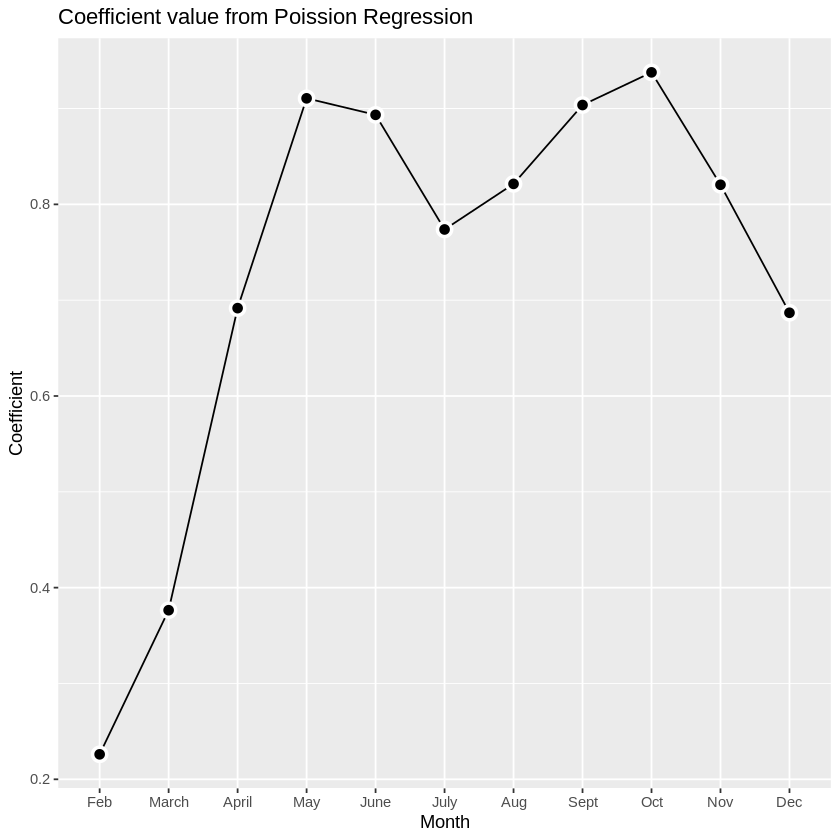

In [20]:
pois_fit_coef_mnths <- 
  tidy(pois_fit) %>% 
  filter(grepl("^mnth", term)) %>% 
  mutate(
    term = stringr::str_replace(term, "mnth_", ""),
    term = forcats::fct_inorder(term)
  ) 

pois_fit_coef_mnths %>% 
  ggplot(aes(term, estimate)) +
  geom_line(group = 1) +
  geom_point(shape = 21, size = 3, stroke = 1.5, 
             fill = "black", color = "white") +
  labs(title = "Coefficient value from Poission Regression",
       x = "Month", y = "Coefficient")

We can similarly also look at the coefficients corresponding to the hr variable. Here the peaks occur at `8:00 AM` and `5:00 PM`, i.e. during normal office start and end times.

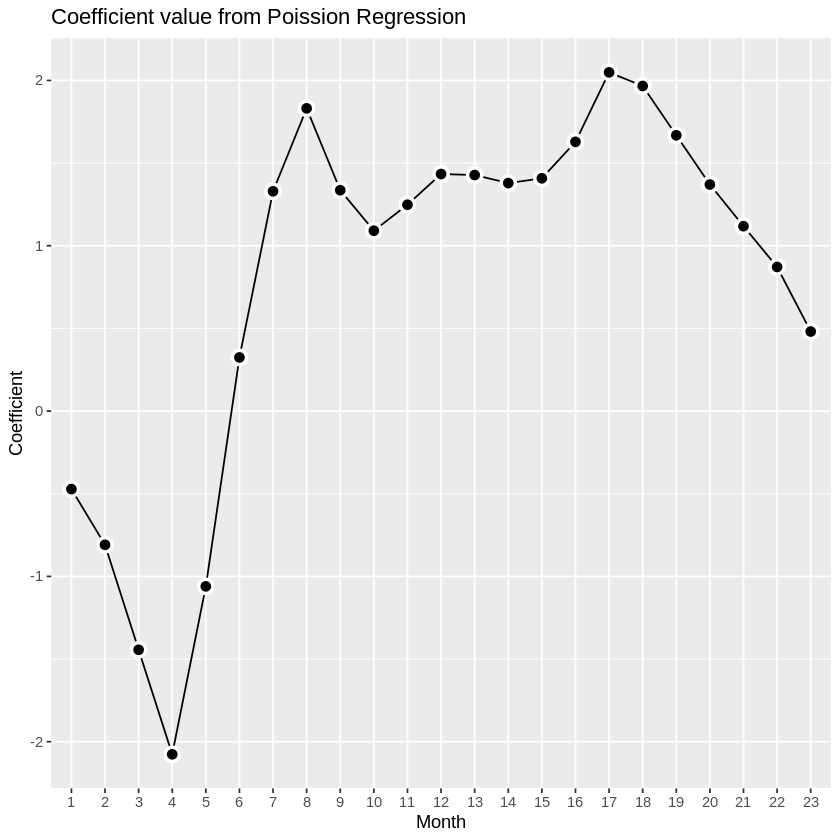

In [21]:
pois_fit_coef_hr <- 
  tidy(pois_fit) %>% 
  filter(grepl("^hr", term)) %>% 
  mutate(
    term = stringr::str_replace(term, "hr_X", ""),
    term = forcats::fct_inorder(term)
  )

pois_fit_coef_hr %>% 
  ggplot(aes(term, estimate)) +
  geom_line(group = 1) +
  geom_point(shape = 21, size = 3, stroke = 1.5, 
             fill = "black", color = "white") +
  labs(title = "Coefficient value from Poission Regression",
       x = "Month", y = "Coefficient")